In [7]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import backend as K

In [8]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [9]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
# Preprocess data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [11]:
# Build CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 46s 766us/sample - loss: 0.1334 - accuracy: 0.9581 - val_loss: 0.0507 - val_accuracy: 0.9836
Epoch 2/5
60000/60000 [==============================] - 46s 771us/sample - loss: 0.0422 - accuracy: 0.9871 - val_loss: 0.0462 - val_accuracy: 0.9855
Epoch 3/5
60000/60000 [==============================] - 45s 758us/sample - loss: 0.0281 - accuracy: 0.9909 - val_loss: 0.0294 - val_accuracy: 0.9905
Epoch 4/5
60000/60000 [==============================] - 45s 751us/sample - loss: 0.0204 - accuracy: 0.9935 - val_loss: 0.0330 - val_accuracy: 0.9898
Epoch 5/5
60000/60000 [==============================] - 47s 777us/sample - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0324 - val_accuracy: 0.9900


In [14]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03244904567482299
Test accuracy: 0.99


In [15]:
# Function to compute Integrated Gradients
def integrated_gradients(input_image, target_class_index, model, steps=50):
    baseline = np.zeros_like(input_image)
    input_image = input_image.astype('float32')
    input_image = np.expand_dims(input_image, axis=0)
    baseline = np.expand_dims(baseline, axis=0)
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    gradient = K.gradients(model.output[:, target_class_index], model.input)[0]
    integrated_gradients = K.function([model.input], [gradient])
    total_gradients = np.zeros_like(input_image)
    for i in range(steps + 1):
        total_gradients += integrated_gradients([scaled_inputs[i]])[0]
    avg_gradients = total_gradients / (steps + 1)
    avg_gradients = np.squeeze(avg_gradients, axis=0)
    return avg_gradients

In [16]:
# Select a random sample from test set for explanation
sample_index = np.random.randint(0, X_test.shape[0])
input_image = X_test[sample_index]

In [17]:
# Predict the class
predicted_class = np.argmax(model.predict(np.expand_dims(input_image, axis=0)))

In [18]:
# Compute Integrated Gradients for the predicted class
ig = integrated_gradients(input_image, predicted_class, model)

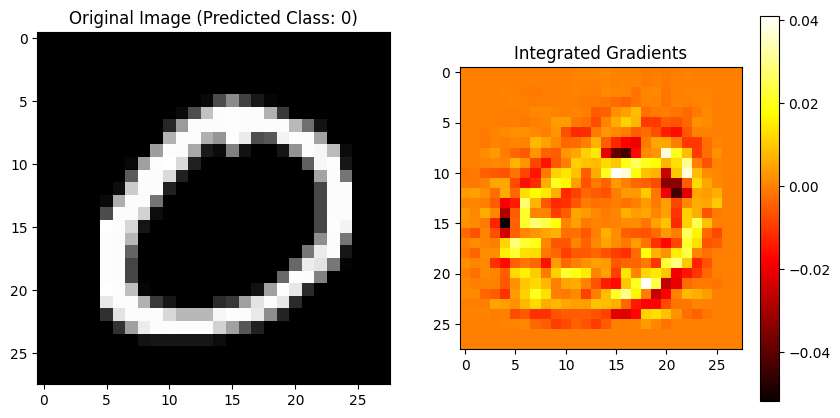

In [19]:
# Plot the original image and the explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze(), cmap='gray')
plt.title('Original Image (Predicted Class: {})'.format(predicted_class))
plt.subplot(1, 2, 2)
plt.imshow(ig.squeeze(), cmap='hot', interpolation='nearest')
plt.title('Integrated Gradients')
plt.colorbar()
plt.show()